In [4]:
#Import required libraries and define dataset paths.

#This step ensures we can load data, manipulate images, and visualize results.

import os
from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random

# Set base dataset folder
DATA_ROOT = "../data"

# Define subdirectory paths for Flooded & Non-Flooded image/mask pairs
TRAIN_FLOODED_IMG = os.path.join(DATA_ROOT, "Train/Labeled/Flooded/image")
TRAIN_FLOODED_MASK = os.path.join(DATA_ROOT, "Train/Labeled/Flooded/mask")

TRAIN_NONFLOODED_IMG = os.path.join(DATA_ROOT, "Train/Labeled/Non-Flooded/image")
TRAIN_NONFLOODED_MASK = os.path.join(DATA_ROOT, "Train/Labeled/Non-Flooded/mask")

# Validation and Test folders (images only, no masks provided)
VAL_IMG_DIR  = os.path.join(DATA_ROOT, "Validation/image")
TEST_IMG_DIR = os.path.join(DATA_ROOT, "Test/image")

In [5]:
# Load all training images and masks, and validation/test images.

# We use glob to collect file paths automatically based on extensions.

train_images = sorted(
    glob(os.path.join(TRAIN_FLOODED_IMG, "*.jpg")) +
    glob(os.path.join(TRAIN_NONFLOODED_IMG, "*.jpg"))
)

train_masks = sorted(
    glob(os.path.join(TRAIN_FLOODED_MASK, "*.png")) +
    glob(os.path.join(TRAIN_NONFLOODED_MASK, "*.png"))
)

val_images = sorted(glob(os.path.join(VAL_IMG_DIR, "*.jpg")))
test_images = sorted(glob(os.path.join(TEST_IMG_DIR, "*.jpg")))

# Print dataset size summary
print(f"Train images: {len(train_images)}")
print(f"Train masks : {len(train_masks)}")
print(f"Val images  : {len(val_images)}")   # no masks
print(f"Test images : {len(test_images)}") # no masks

Train images: 398
Train masks : 398
Val images  : 450
Test images : 448


In [6]:
# Verify that training image files correctly match mask files by comparing filenames (without extensions).

# This ensures there is no label mismatch.

for i in range(5):
    print(os.path.basename(train_images[i]), "-->", os.path.basename(train_masks[i]))

10165.jpg --> 10165_lab.png
10166.jpg --> 10166_lab.png
6279.jpg --> 6279_lab.png
6614.jpg --> 6614_lab.png
6615.jpg --> 6615_lab.png


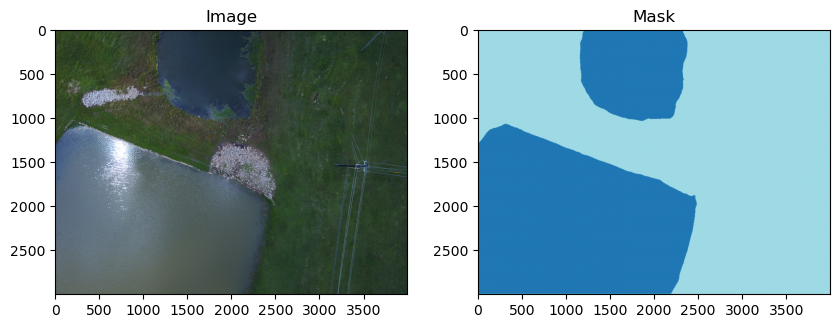

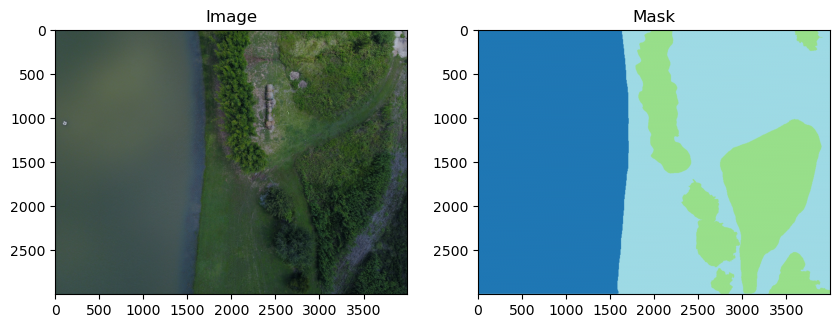

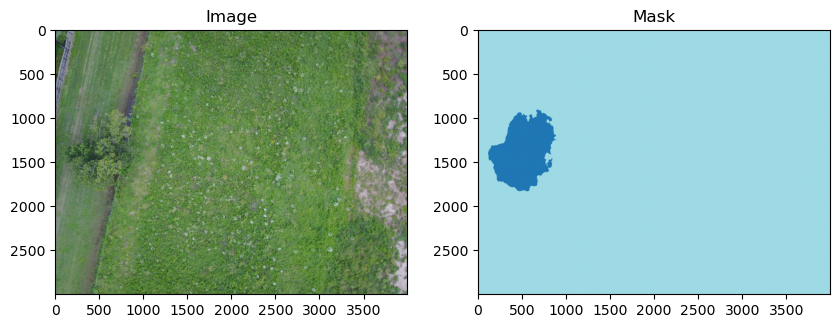

In [8]:
# Randomly display input image and corresponding segmentation mask.

# This helps visually confirm correct annotation and spatial alignment.

def show_random_samples(n=3):
    for _ in range(n):
        idx = random.randint(0, len(train_images)-1)

        # Load image and mask
        img = np.array(Image.open(train_images[idx]))
        mask = np.array(Image.open(train_masks[idx]))

        # Plot side-by-side
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img)
        ax[0].set_title("Image")
        ax[1].imshow(mask, cmap='tab20')   # use categorical colormap
        ax[1].set_title("Mask")
        plt.show()

show_random_samples(3)

In [9]:
# Check unique pixel values in masks to determine number of segmentation classes.

# This dataset uses integer encoding for semantic labels.

all_vals = set()
for m in random.sample(train_masks, 20):
    all_vals |= set(np.unique(np.array(Image.open(m))))

print(all_vals)

{np.uint8(0), np.uint8(1), np.uint8(2), np.uint8(3), np.uint8(4), np.uint8(5), np.uint8(6), np.uint8(7), np.uint8(8), np.uint8(9)}


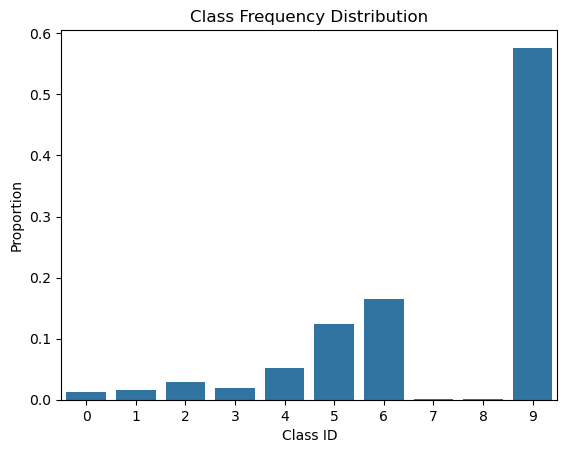

Class distribution: [0.01332071 0.01602218 0.02979083 0.01902516 0.05253696 0.12357565
 0.16549432 0.00182251 0.00192588 0.57648581]


In [10]:
# Compute frequency of each class (0–9) across all masks.

# We sum how many pixels belong to each class. This reveals data imbalance, critical for loss function choice.

class_counts = np.zeros(10)  # 10 classes

for m in train_masks:
    mask = np.array(Image.open(m))
    for cls in range(10):
        class_counts[cls] += np.sum(mask == cls)

# Normalize pixel count → gives class proportion
class_dist = class_counts / class_counts.sum()

# Plot distribution
sns.barplot(x=list(range(10)), y=class_dist)
plt.title("Class Frequency Distribution")
plt.xlabel("Class ID")
plt.ylabel("Proportion")
plt.show()

print("Class distribution:", class_dist)

In [11]:
# Check original resolution of sample images.

# FloodNet uses large drone imagery (3K–4K). We will resize later.

dims = [np.array(Image.open(img)).shape for img in random.sample(train_images, 10)]
dims[:5]

[(3000, 4000, 3),
 (3000, 4000, 3),
 (3000, 4000, 3),
 (3000, 4000, 3),
 (3000, 4000, 3)]

In [12]:
# Dataset Understanding Summary

# - Dataset: FloodNet Track-1 UAV flood segmentation dataset
# - Training set: 398 images with corresponding masks
# - Validation and test sets: images only, no masks provided
# - Image-mask filename alignment confirmed
# - Mask values range from 0 to 9, indicating 10 semantic classes
# - Class frequency distribution is imbalanced, with class 9 dominating a large portion of pixels
# - Images are high resolution, typically between 3000 and 4500 pixels in width/height
# - Visual inspection confirms correct spatial alignment between images and masks

# Next step: perform preprocessing, including resizing, normalization, and data augmentation